# Estimating Missing Data in Temporal Data Streams Using Multi-directional Recurrent Neural Networks

Paper by: Jinsung Yoon, William R. Zamey, and Mihaela van der Schaar  
Published in: IEEE Transactions on Biomedical Engineering  
Year: 2017  

Hands-On Notebook by:  
Simon Boeder, 305955

## Notation

The dataset consists of $N$ time series with $D$ channels and length $T$.  

$$X_n = \begin{bmatrix} 2 &4 &8 & \ast \\ 5 & \ast & 9 & 10 \end{bmatrix} \quad D= 2 , T=4$$

Missing values:
$$x_t^d = \ast$$

Binary mask:
$$m =   \begin{bmatrix} 1 &1 &1 & 0 \\ 1 & 0 & 1& 1 \end{bmatrix}$$

Time to last measurement:

$$\delta = \begin{bmatrix} 0 &1 &1.2 & 1 \\ 0 & 1 & 3 & 1.4 \end{bmatrix}$$

## Motivation

The goal of the M-RNN model is to estimate the missing values in time series data. To do that, the M-RNN solves a sequence to sequence problem, in that the input $x$ (that is potentially missing) should be reconstructed to $\hat{x}$ with minimal loss as shown in the image below. 

<img src="seq2seq.png" alt="Drawing" style="width: 700px;"/>


Typically, there are two main approaches to compute missing values in a time series:

- <b>Interpolation</b>: These methods use the correlation between measurements at different time steps $t$ <b>within</b> one stream $d$ of the time series to predict the missing values. (Examples: [3] [4])
- <b>Imputation</b>: Imputation methods on the other hand exploit information of measurements of the <b>same</b> time $t$ but across their different channels to estimate the missing values. (Examples: \[2\] \[5\]) 

We can see here that both types only exploit a single dimension to estimate the missing values and hence potentially neglect valuable information. The M-RNN model wants to combine both interpolation and imputation to use all possible information to compute the missing values.

## Model

To do the above task, the authors introduce a novel model called M-RNN, which consists of two components, the interpolater and the imputer. The interpolater uses a Bi-directional Recurrent Neural Network (Bi-RNN) to interpolate missing values within each channel along the time dimension. Afterwards, the imputer will compute an estimate for each time step along all channels using a simple fully connected neural network (FCNN). The image below should show the idea. 

![title](inter-imput.png)


Now the question may rise: <b> How does the model compute $\hat{x}_{t=n}$ if $x_{t=n}$ is missing? Doesn't it need an input $x$ to compute the output?</b>  
This is where the contribution of this paper comes into play. 


Let's look at the interpolater first. In the standard Bi-RNN architecture, the hidden states are calculated by using the hidden state of the previous time step and the observation of the current time step (or the next hidden state and the current observation for the backward direction). In the M-RNN however, the hidden state is calculated using the previous hidden state and also the <b>previous</b> observation for the forward RNN, and the next hidden state and <b>next</b> observation for the backward RNN. The difference between the models is shown below. 

<img src="birnn.png" alt="Drawing" style="width: 800px;"/>

<img src="mrnn.png" alt="Drawing" style="width: 800px;"/>


This architecture makes sure that we <b>never use the current observation to compute its hidden state representation</b>. Hence, to compute the intermediate estimated value $\tilde{x}_t$, we will never use information from $x_t$, so it does not matter whether we have actually measured this point or not. 

Next, we look at the imputer. As said above, we use a simple FCNN to implement this component. The imputer takes the intermediate estimations $\tilde{x}_t$ and outputs the final point estimates $\hat{x}$. The image below shows the intuition behind the imputer.

<img src="imputer.png" alt="Drawing" style="width: 700px;"/>


## Implementation

Now we can implement the model. In the implementation of the authors, GRU cells (with u,r gate and memory cell c) are used, but here we stick to vanilla RNN for simplicity purposes. We will use PyTorch to implement the model and make use of the autograd feature of PyTorch to train the model. In the end, we will have a ready to use PyTorch Module of the M-RNN method.

In [60]:
# Import utilities for MRNN 
%run utils_mrnn.ipynb

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from torch.nn import Parameter
from torch.nn.init import xavier_uniform_

In [62]:
# Use cuda (GPU) to train models if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.FloatTensor')

Throughout the implementation, I will try to demonstrate the computations with a very small example before we apply the method to a real dataset:

In [63]:
np.random.seed(123)
f = np.array([1.5,2,2.5])
offset = np.array([0,1,2]).reshape(-1,1)
w = 2. * np.pi * f
t = np.linspace(0, 1, 50)
x = torch.tensor(np.sin(w.reshape(-1,1) * t)+offset).float()
ground_truth = x.detach().clone()
mask = torch.ones_like(x)
delta = torch.ones_like(x).float()
delta[:,0] = 0

# remove 5% of the data
ix = [(channel,t) for channel in range(x.shape[0]) for t in range(x.shape[1])]
np.random.shuffle(ix)
to_replace = int(round(.05*len(ix)))
ix = ix[:to_replace]
for idx in ix:
    x[idx[0],idx[1]] = np.nan
    mask[idx[0],idx[1]] = 0

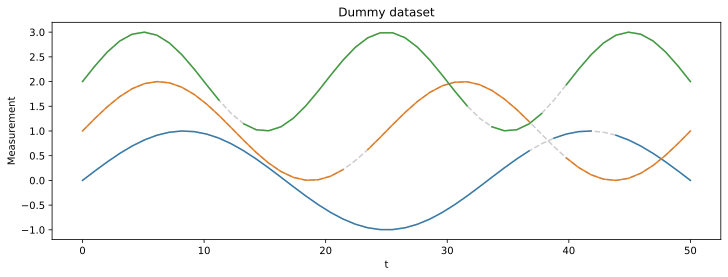

In [64]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12,4))
plt.title("Dummy dataset")
plt.xlabel("t")
plt.ylabel("Measurement")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),alpha=0.4,c="grey",linestyle='dashed')

### Interpolater

First, we implement the interpolater network. As said earlier, we use a Bi-RNN, but lag the input from $t-1$ for the forward RNN and from $t+1$ for the backward RNN. Because we interpolate independently within each channel, <b>we learn one set of weights for each channel</b>. This network can be described with the following formulas (taken from the paper):

Hidden states:  
$$\overrightarrow{h}_t^d = ReLU(\overrightarrow{W}^d  \overrightarrow{h}_{t-1}^d + \overrightarrow{V}^d  z^d_{t-1} + \overrightarrow{c}^d)$$ 
$$\overleftarrow{h}_t^d = ReLU(\overleftarrow{W}^d  \overleftarrow{h}_{t+1}^d + \overleftarrow{V}^d  z^d_{t+1} + \overleftarrow{c}^d) $$

With the weight matrices $\overleftarrow{W}$, $\overrightarrow{W}$,$\overleftarrow{V}$, $\overrightarrow{V}$,$\overleftarrow{c}$, $\overrightarrow{c}$.  
Where $z^d_t = [x^d_t,m^d_t,\delta^d_t]$ the concatenation of the input.  

<br><br>
Using our dummy dataset, let's compute the forward hidden state for the time step $t=13$ in the third channel $d=3$. Let's assume we use a hidden dimension size of 3 and the previous hidden state of the third channel was $\overrightarrow{h}_{12}^3 = \begin{bmatrix} 2 \\4 \\3\end{bmatrix}$. Then, the next hidden state is:

$$\overrightarrow{h}_{13}^3 = ReLU(\overrightarrow{W}^3  \overrightarrow{h}_{12}^3 + \overrightarrow{V}^3  z^3_{12} + \overrightarrow{c}^3) = ReLU (\overrightarrow{W}^3 \begin{bmatrix} 2 \\4 \\3\end{bmatrix} + \overrightarrow{V}^3 \begin{bmatrix} 1.6247 \\1 \\1\end{bmatrix} + \overrightarrow{c}^3)$$ 

In [65]:
# Forward estimate
hf_t12_d3 = np.array([2,4,3]) # Forward Hidden state of t-1

Wf3 = np.array([[ 0.1546, -0.6600,  0.5753],
        [-0.0077, -0.6195,  0.1414],
        [ 0.2404,  0.1764,  0.7104]]) # 3x3 weight matrix W^1
Vf3 = np.array([[-0.5855, -0.5765,  0.9371],
        [-0.5110,  0.3941,  0.5218],
        [-0.5413,  0.4935, -0.2625]]) # 3x3 weight matrix V^1
cf3 = np.array([-0.9524, -1.1768, -1.0417]) # 3x1 weight matrix V^1

hf_t13_d3 = ReLU(Wf3.dot(hf_t12_d3) + Vf3.dot(np.array([1.6247,1,1])) + cf3) # Calculate result

print(" The forward hidden state of t=13 and d=3 is: ",hf_t13_d3)

 The forward hidden state of t=13 and d=3 is:  [-0.         -0.          1.62744989]


When all hidden states for all timesteps and channels are computed, the intermediate estimate can be computed by combining the forward and backward hidden states:

Intermediate estimate:  
$$\tilde{x}^d_t = ReLU(U^d  [\overrightarrow{h}_t^d ; \overleftarrow{h}_t^d ] + c^d_0)$$

With the weight matrices $U$,$c_0$.  

Here is an example of how to compute the estimation $\tilde{x}^3_{13}$. We have already computed the forward hidden state $\overrightarrow{h}_{13}^3$ for this timestep and channel above. Let's assume the backward hidden state is $\overleftarrow{h}_{13}^3 = \begin{bmatrix} 0.3 \\1.5 \\2.75\end{bmatrix}$.

$$\tilde{x}^3_{13} = ReLU(U^3 \left[\begin{pmatrix} 0\\0\\1.62744989 \end{pmatrix} ; \begin{pmatrix} 0.3 \\1.5 \\2.75\end{pmatrix} \right] + c^3_0)$$

In [66]:
hb_t13_d3 = np.array([-1,1.5,2.75]) # Backward Hidden state of t
U3 = np.array([ 0.2740,  0.6337,  0.8451, -1.1979,  0.4775, -0.4943]) # 1x6 Weight matrix U^1
c_3_0 = np.array([-0.2885]) # 1x1 bias c_0^1

x_tilde_t13_d3 = ReLU(U3.dot(np.concatenate((hf_t13_d3,hb_t13_d3))) + c_3_0) # compute result
print("Intermediate estimate for t=13 and d=3: ", x_tilde_t13_d3)

Intermediate estimate for t=13 and d=3:  [1.6416829]


Let's see what the output of the interpolater looks like on our dummy dataset:

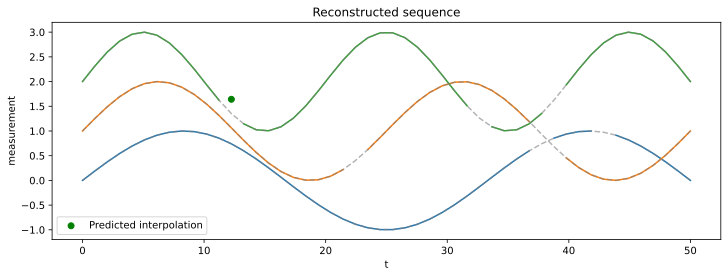

In [67]:
# Dummy dataset output
plt.figure(figsize=(12,4))
plt.title("Reconstructed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)
plt.scatter(t[12]*50,x_tilde_t13_d3,c="green",label="Predicted interpolation")
plt.legend()

It looks like we have to compute the interpolater output for each time step and each channel individually. In order to speed this up, we can arrange the weight matrices in a blockdiagonal fashion, where the weights for the channels are one block each, like shown below. This way, we can compute the estimate for every channel at time $t$ for all channels at once. My implementation uses this trick. 

$$\overrightarrow{W} =  \begin{bmatrix} \overrightarrow{W}^1 & 0 & ... & 0 \\ 0 & \overrightarrow{W}^2 & ... & 0\\ 0&0&...&0 \\ ... & ... & ...& ...\\ 0&0&...& \overrightarrow{W}^D\end{bmatrix}$$



Since we do not use a standard RNN but use inputs from different time steps, we can not use the RNN PyTorch module here. Instead, we have to implement this behavior ourselves. Because of that, all weights are implemented as "PyTorch parameters". A PyTorch implementation can look like the following:

In [68]:
class interpolater(nn.Module):
    '''Interpolater Module for the M-RNN model.'''
    def __init__(self,nchannels,hidden_dim,seq_len,padding="replication",act='relu'):
        super(interpolater, self).__init__()
        self.nchannels = nchannels
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        # Activation function
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        
        # Forward RNN weights
        self.Wf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cf = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Backward RNN weights
        self.Wb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,hidden_dim).to(device=device))))
        self.Vb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,3).to(device=device))))
        self.cb = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,hidden_dim,1).to(device=device))))

        # Hidden state weights (combine forward and backward)
        self.U = Parameter(block_diag(xavier_uniform_(torch.FloatTensor(nchannels,1,hidden_dim*2).to(device=device))))
        self.c0 = Parameter(block_diag(nn.init.normal_(torch.FloatTensor(nchannels,1,1),std=.1).to(device=device)))
        
        # Padding options
        if padding == "replication":
            self.pad = nn.ReplicationPad2d((1,1,0,0))
        elif padding == "zero":
            self.pad = nn.ZeroPad2d((1,1,0,0))
            
    def forward(self,x,m,d):
        '''A forward pass through the interpolater. This function will go through all time steps.
        Input:
        x = Measurement
        m = Mask (1=observed, 0=missing)
        d = time elapsed since last observation
        
        Output:
        Estimate x_est for every input time step.'''
        
        batchsize = x.shape[0]
        # Initialize hidden states
        hidden_forwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        hidden_backwards = [torch.zeros(batchsize,self.hidden_dim*self.nchannels,self.nchannels)]
        
        # Append zeros to beginning and end of input
        x = self.pad(x.unsqueeze(0)).squeeze(0)
        m = self.pad(m.unsqueeze(0)).squeeze(0)
        d = self.pad(d.unsqueeze(0)).squeeze(0)
        
        # Iterate through time (backward and forward)
        for t in range(self.seq_len):  
            # forward RNN hidden states
            hidden_f = self.act(torch.matmul(self.Wf,hidden_forwards[t]) + torch.matmul(self.Vf,
                block_diag(torch.stack((x[:,:,t],m[:,:,t],d[:,:,t]),axis=2).view(-1,self.nchannels,3,1))) 
                +self.cf)
            
            # backward RNN hidden states
            hidden_b = self.act(torch.matmul(self.Wb,hidden_backwards[t]) + 
                  torch.matmul(self.Vb,block_diag(torch.stack((x[:,:,self.seq_len+1-t],m[:,:,self.seq_len+1-t],
                  d[:,:,self.seq_len+1-t]),axis=2).view(-1,self.nchannels,3,1))) 
                  + self.cb)
            
            hidden_forwards.append(hidden_f)
            hidden_backwards.append(hidden_b)

        hidden_forwards = hidden_forwards[1:] # delete state t=-1
        hidden_backwards = hidden_backwards[1:][::-1] # delete state t=T+1 and reverse the list
        
        final_hidden=torch.empty(batchsize,self.nchannels,self.seq_len)
        
        # Iterate through time again and compute combined state
        for t in range(self.seq_len):
            hidden = self.act(torch.matmul(self.U,block_diag(torch.cat((
                unblock_diag(hidden_forwards[t],n=self.nchannels,size_block=(self.hidden_dim,1)),
                unblock_diag(hidden_backwards[t],n=self.nchannels,size_block=(self.hidden_dim,1))),axis=2))) 
                + self.c0)
            
            final_hidden[:,:,t]= unblock_diag(hidden,n=self.nchannels).flatten(1)
            
        return final_hidden

### Imputer

Now that the interpolater is implemented, we can implement the imputer module. This one is much easier, as we can use the standard Linear layers of PyTorch as our fully connected network. In formulas, the imputer looks as follows (again, taken and simplified from the paper):

$$h_t = ReLU(U x_t + V^1 \tilde{x}_t + V^2 m_t + \beta)$$
$$\hat{x}_t = W h_t + \alpha$$

With $z_t = [\tilde{x}_t, m_t]$ the concatenation of the interpolater output and the mask.  
With weight matrices $U$, $V^1$, $V^2$ and $W$ and biases $\beta$ and $\alpha$.  

As we can see, we also use the observed measures $x$ here as well. To make sure we do <b> not </b>use $x_t^d$ to compute $\hat{x}^d_t$, the weight matrix $U$ must have $0$'s on the diagonal. This makes sure that the estimated point again does not use any information of the ground truth, as this point might be missing.

So for example:

$$ U * x_{t=1} = \begin{bmatrix} 0 & U_{1,2}  & ... & U_{1,D} \\
                                  U_{2,1} & 0 & ... & U_{2,D} \\  U_{3,1} & U_{3,2} & ... & U_{3,D}\\
                                  ... & ... & ... & ...\\
                                  U_{D,1} & U_{D,2} & ... & 0\end{bmatrix}  * \begin{bmatrix} x_1^1 \\ x_1^2 \\x_1^3 \\ ... \\x_1^D \end{bmatrix} $$   
                                  
<br>           <br>                       
                                  
Using our dummy example, we can compute the final output $\hat{x}_{13}$ now. We have already computed the intermediate estimate $\tilde{x}_{13}^3$ above. To compute the final output, we need the intermediate estimate of this timestep from all other channels. Let's assume $\tilde{x}_{13}^1 = \begin{bmatrix} 1.125\end{bmatrix}$ and $\tilde{x}_{13}^2 = \begin{bmatrix} 0.565\end{bmatrix}$. Then, the final hidden output will be:

$$h_{13} = ReLU\left( \quad\begin{bmatrix} 0 & U_{1,2} & U_{1,3} \\ U_{2,1} & 0 & U_{2,3}\\ U_{3,1} & U_{3,2} & 0\end{bmatrix} \begin{bmatrix} 2 \\ 4 \\ 3\end{bmatrix} \quad + \quad\begin{bmatrix} V^1_{1,1} & V^1_{1,2}& V^1_{1,3} \\ V^1_{2,1} & V^1_{2,2} & V^1_{2,3} \\ V^1_{3,1}& V^1_{3,2}& V^1_{3,3}\end{bmatrix} \begin{bmatrix}  1.125 \\ 0.565 \\1.642 \end{bmatrix}\quad + \quad\begin{bmatrix} V^2_{1,1} & V^2_{1,2}& V^2_{1,3} \\ V^2_{2,1} & V^2_{2,2} & V^2_{2,3} \\ V^2_{3,1}& V^2_{3,2}& V^2_{3,3}\end{bmatrix} \begin{bmatrix} 1\\1\\1 \end{bmatrix}\quad + \quad\begin{bmatrix} \beta^1\\\beta^2\\ \beta^3 \end{bmatrix}\quad\right)$$ 



In [69]:
U = np.array([[ 0.0000, -0.5917, -0.4022],
        [ 0.0718,  0.0000,  0.7470],
        [-0.1493,  0.0946,  0.0000]]) # 3x3 weight matrix with 0 on diagonal
V1 = np.array([[-0.4108, -0.4928,  0.0758],
        [ 0.1374,  0.1361, -0.1438],
        [-0.5133, -0.5428, -0.0387]]) # 3x3 weight matrix
V2 = np.array([[-0.2221, -0.6349, -0.4399],
        [ 0.5302, -0.0099, -0.5198],
        [-0.3753, -0.8754, -0.5621]]) # 3x3 weight matrix
beta = np.array([-0.2132,  0.6235, -0.1733]) # 3x1 bias matrix

x_tilde_t13 = np.array((0.125,1.565,x_tilde_t13_d3.item())) # combined intermediate estimates

# compute result
h_13 = ReLU(U.dot(np.array([0.7403,1.0641,1.642])) + V1.dot(x_tilde_t13) + V1.dot(x_tilde_t13) + beta)
print("Imputer hidden state of t=13: ",h_13)

Imputer hidden state of t=13:  [-0.          1.89142254 -0.        ]


Finally, the hidden state is forwarded a last time to compute the final estimate $\hat{x}$:

$$ \hat{x}_{13} = \begin{bmatrix} W_{1,1} & W_{1,2}& W_{1,3} \\ W_{2,1} & W_{2,2} & W_{2,3} \\ W_{3,1}& W_{3,2}& W_{3,3}\end{bmatrix}  \begin{bmatrix} h_{13}^1 \\ h_{13}^2 \\h_{13}^3 \end{bmatrix} +  \begin{bmatrix} \alpha\end{bmatrix} $$

In [70]:
W = np.array([[-0.1957, -0.0024, -0.3857],
        [ 0.0047,  0.5593, -0.2730],
        [-0.0396,  0.5180,  0.2218]]) # 3x3 weight matrix
alpha = np.array([ 0.5846, 0.3176,  0.49670]) # 1x1 bias

# compute result
x_hat_13 = W.dot(h_13) + alpha
print("Final output of t=13: ",x_hat_13)

Final output of t=13:  [0.58006059 1.37547263 1.47645687]


Again, we can see what the final imputer output looks like:

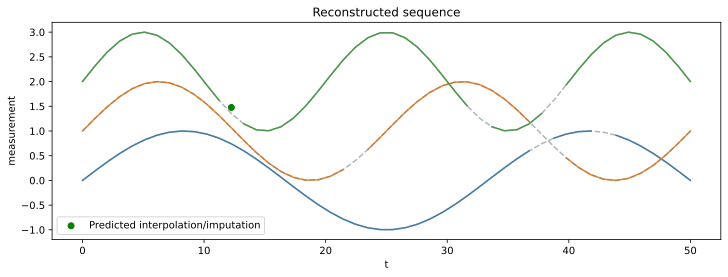

In [71]:
# Dummy dataset output
plt.figure(figsize=(12,4))
plt.title("Reconstructed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x[i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)
plt.scatter(t[12]*50,x_hat_13[2],c="green",label="Predicted interpolation/imputation")
plt.legend()

We can see that the imputer outputs the predicted reconstruction of all channels in one timestep (which is why we have 3 values in the output, because we have 3 channels). The complete implementation in PyTorch may look like this:

In [72]:
class imputer(nn.Module):
    '''Fully connected network that computes the imputation across data streams. We can use the time dimension
    as the batch dimension here, as the linear layers are independent of time.'''
    def __init__(self,n_channels,hidden_dim=3,act='relu'):
        super(imputer, self).__init__()
        if act == 'relu':
            self.act = F.relu
        elif act == 'tanh':
            self.act = F.tanh
        self.V1 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.V2 = nn.Linear(n_channels,hidden_dim,bias=False)
        self.U = nn.Linear(n_channels,hidden_dim) # bias beta
        self.W = nn.Linear(hidden_dim,n_channels) # bias alpha
        
    def forward(self,x,x_est,m):
        '''x : true measurement
        x_est : estimated measurement of the interpolater
        m : mask'''
        v1out = self.V1(x_est.permute(0,2,1))
        v2out = self.V2(m.permute(0,2,1))
        self.U.weight.data.fill_diagonal_(0) # diagonal to zero to prevent usage of x_t^d at for prediction x_hat_t^d
        uout = self.U(x.permute(0,2,1)) 
        h = self.act(uout+v1out+v2out) # hidden layer
        out = self.W(h) # output layer, linear activation here
        return out.permute(0,2,1)

### Combined Model

We have now implemented both components of the M-RNN model. We will combine them in a single PyTorch module so that we have a single model that handles the complete training and inference. This class implements a "fit()" and "predict()" function to train the model and to predict new sequences.

In [73]:
class MRNN(nn.Module):
    def __init__(self,nchannels,seq_len,hidden_dim_inter,hidden_dim_imp=3,verbose=False,padding="replication",act='relu'):
        super(MRNN, self).__init__()
        self.inter = interpolater(nchannels,hidden_dim_inter,seq_len,padding=padding,act=act)
        self.imp = imputer(nchannels,hidden_dim_imp,act=act)
        self.verbose = verbose
        
    def forward(self,x,m,d):
        '''x = measurements, m = mask, d = time delta between measurements'''
        out = self.inter.forward(x,m,d)
        out = self.imp.forward(x,out,m)
        return out
    
    def fit(self,epochs,optimizer,loss_func,batch_size,x,m,d):
        loss_hist = []
        # Make initial interpolation
        x = initial_interpolation(x,m)

        # Iterate over epochs
        pbar = tqdm(range(epochs))
        for i in pbar:   
            # shuffle dataset
            indices = torch.randperm(x.shape[0])
            x = x[indices]
            m = m[indices]
            d = d[indices]
            
            temp_loss_hist=[]
            # Iterate over all batches
            for batch in range(int(x.shape[0] / batch_size)):
                x_b = x[batch*batch_size:(batch+1)*batch_size]
                m_b = m[batch*batch_size:(batch+1)*batch_size]
                d_b = d[batch*batch_size:(batch+1)*batch_size]
                # Estimate all values (forward pass)
                output = self.forward(x_b,m_b,d_b)
                # Compute loss
                loss = loss_func(m_b*output,m_b*x_b) # only use loss of actually observed measurements
                # Backward the loss
                optimizer.zero_grad()
                loss.backward()
                temp_loss_hist.append(loss)
                # Update the weights
                optimizer.step()
            if self.verbose:
                # print graph
                x_hat = self.predict(x,m,d)
                missing = (m!=1)
                live_plot(x_hat[0],missing[0],x[0],title=i)
                
            loss_hist.append(torch.stack(temp_loss_hist).mean())
            pbar.set_postfix({'loss': torch.stack(temp_loss_hist).mean()})
             
        return loss_hist
    
    def predict(self,x,m,d,replace=False):
        with torch.no_grad():
            # initial interpolation
            x = initial_interpolation(x,m)
            # Forward dataset
            out = self.forward(x,m,d)
            if replace:
                observed = (m==1)
                out[observed] = x[observed]
                
        return out        

### Initial interploation needed

Before we can train a model and test the code, there is one last thing that we have to do. If we have missing data in $x_t$, then we have no input for the next point estimate $x_{t+1}$. The authors do not provide information on how to solve this, so there are two options:

- if $x_t$ is missing, use the last actual observed measurement $x_{t-n}$ to compute $\hat{x}_t$.
- Use a simple initial interpolation method like the mean of the next and previous sample to have a value to compute with.

We will use the second option for simplicity purposes, as the first method makes the implementation more complicated and less efficient. We can find that the authors also use the second option in their Tensorflow implementation [7].

In [74]:
def initial_interpolation(x_in,m):
    '''Uses simple mean interpolation to replace NaNs in the data. The learning will only be done on non NaN measurements'''
    x = x_in.clone()
    for b in range(x.shape[0]):
        for stream in range(x.shape[1]):
            for step in range(x.shape[2]):
                if m[b,stream,step]==0:
                    if step==0:# first step has no previous step
                        i = 1
                        while(torch.isnan(x[b,stream,step+i])):
                            i+=1
                        x[b,stream,step] = x[b,stream,step+i] # equal to next non-nan step
                        
                    elif step==(x.shape[2]-1):# last step has no next step
                        x[b,stream,step] = x[b,stream,step-1] # equal to previous step
                    else: 
                        i=1
                        while(torch.isnan(x[b,stream,step+i])):
                            if step+i+1 < (x.shape[2]-1):
                                i+=1
                            else:
                                break
                        if torch.isnan(x[b,stream,step+i]):
                            nextstep = x[b,stream,step-1]
                        else: 
                            nextstep = x[b,stream,step+i]
                        x[b,stream,step] = (x[b,stream,step-1] + nextstep)/2 # Mean of previous and next non-nan if available
    return x

## Train on dummy dataset

Let's try out the model on the dummy dataset from the beginning to the end, and test out how the algorithm works.  

As mentioned above, the loss will be the reconstruction loss between our estimated points $\hat{x}$ and the ground truth $x$. If we minimize this loss, we are getting better and better at correctly estimating the points. As we can only learn from samples that we actually measured (if $x_t$ is missing, we have no ground truth and can't compute the loss), we use the mask to hide missing samples when computing the loss. This will result in the following loss function:

$$ \mathcal{L}(x,\hat{x}) = \frac{1}{N} \sum_{n=1}^N m(n) * (\hat{x}(n) - x(n))^2$$

In [77]:
torch.manual_seed(7)
dummy_model = MRNN(3,50,32,32,verbose=True,act='tanh')
dummy_optimizer = torch.optim.Adam(dummy_model.parameters(),lr=0.06)
loss_func = nn.MSELoss()
epochs = 40

In [78]:
x_t = x.unsqueeze(0).float().to(device=device)
m_t = mask.unsqueeze(0).float().to(device=device)
d_t = delta.unsqueeze(0).float().to(device=device)

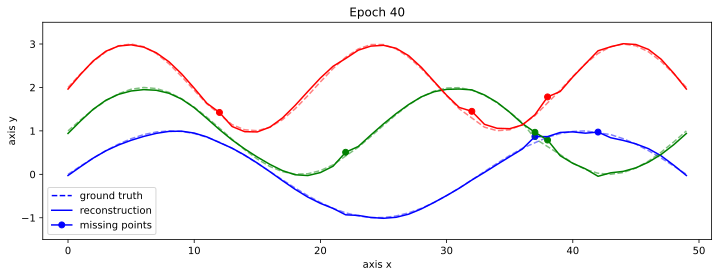

In [80]:
%matplotlib inline
losses = dummy_model.fit(epochs,dummy_optimizer,loss_func,1,x_t,m_t,d_t)

Let's plot the reconstruction! (Keep in mind we highly overfit here)

In [31]:
x_hat = dummy_model.predict(x_t,m_t,d_t,replace=True)

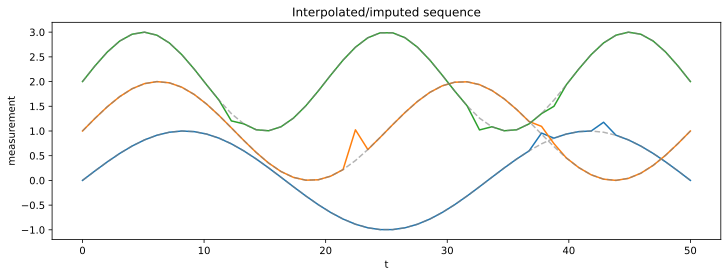

In [32]:
plt.figure(figsize=(12,4))
plt.title("Interpolated/imputed sequence")
plt.ylabel("measurement")
plt.xlabel("t")
for i in range(3):
    plt.plot(t*50,x_hat[0][i].cpu())
    plt.plot(t*50,ground_truth[i].cpu(),linestyle="dashed",c="grey",alpha=0.6)

## Train on real dataset

Now that the model is implemented completely, we can train it on real data and see how it works. For this notebook, we use the EEG Eye State Dataset (https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State). This is a time series dataset that tracks 13 different measures of a person over a certain time, with a binary classification target that is either "eyes closed" (0) or "eyes open" (1). As we are trying to reconstruct the time series data, we do not need the target variable here.

### Preparation
First, we need to load the data. This will be a single, very long time series.

In [33]:
# Load data
data = np.loadtxt("EEG Eye State.arff",delimiter=",")
data = data[:,:-1].T

Next, we will chop the time series into 200 chunks, so that we have 200 multivariate samples.

In [34]:
# Chunk it into sequences
nchunks = 200
chunksize = int(data.shape[1] / nchunks)
chunked=[data[:,chunksize*i:chunksize*(i+1)] for i in range(nchunks)]
data = torch.tensor(np.array(chunked)).float().cuda()

In [35]:
# Lets have a look at the shape
print("Number of samples: ",data.shape[0])
print("Number of channels: ",data.shape[1])
print("Length of time sequence: ",data.shape[2])

Number of samples:  200
Number of channels:  14
Length of time sequence:  74


As we can see, we have 200 samples with length 74 and 14 channels (+ target). For runtime and visualization purposes, let's just use the first 6 channels for this exercise.

In [36]:
# lets just use the first 4 channels
data = data[:,:4,:]

In [37]:
# Prepare mask and delta -> delta is not given in the dataset, hence we will use simple assumptions
mask = torch.ones_like(data).float()
delta = torch.ones_like(data).float()
delta[:,:,0] = 0

This dataset does not have any missing values. For training the model that does not matter, as the model acts as if the points were missing. Nonetheless, it would be nice to see how it fills missing values when there are some. So let's just delete some points.


In [38]:
# Make a ground truth copy
ground_truth = data.detach().clone()
# remove 5% of the data
np.random.seed(5)
ix = [(row,channel, step) for row in range(data.shape[0]) for channel in range(data.shape[1]) for step in range(data.shape[2])]
np.random.shuffle(ix)
to_replace = int(round(.05*len(ix)))
ix = ix[:to_replace]

for idx in ix:
    data[idx[0],idx[1],idx[2]] = np.nan
    mask[idx[0],idx[1],idx[2]] = 0

Now we can have a look at how the data looks. Let's plot some sequenecs: 

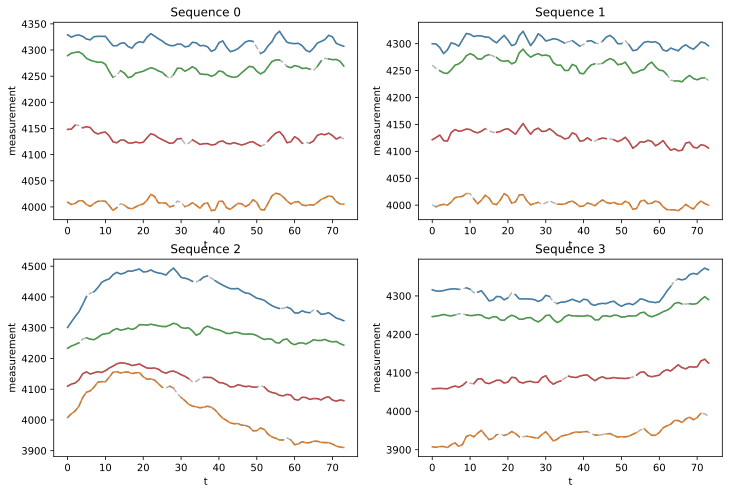

In [39]:
# Plot some sequences
plt.figure(figsize=(12,8))
for pl in range(4):
    plt.subplot(221+pl)
    plt.title("Sequence {}".format(pl))
    plt.xlabel("t")
    plt.ylabel("measurement")
    for dim in range(4):
        plt.plot(np.arange(74),data[pl,dim,:].cpu())
        plt.plot(np.arange(74),ground_truth[pl,dim,:].cpu(),c="grey",linestyle="dashed",alpha=0.6)

### Training

In [ ]:
eye_model = MRNN(4,74,32,32,verbose=False,padding="replication").to(device=device)
optimizer = torch.optim.Adam(eye_model.parameters(),lr=0.005)
loss_func = nn.MSELoss()
epochs = 500

Now we can fit the model using the training data. Unfortunately, the training takes a bit of time (depending on the batchsize, the chosen hidden dimension size and the number of channels), which is why I have pretrained the moel before the presentation.  
<b>Use the second cell to load the model</b>.

In [ ]:
# Fit the model
losses = eye_model.fit(epochs,optimizer,loss_func,80,data,mask,delta)

In [40]:
# or load existing model
eye_model = MRNN(4,74,32,32).to(device=device)
eye_model.load_state_dict(torch.load("eye_state_model2.pt"))

# Load loss histories
with open("trainloss.npy","rb") as f:
    losses = np.load(f,allow_pickle=True)

Now that the training is finished, we can plot the loss curve to see if the model converges. As we can see, the model quickly learns how the sequences behave and is able to reconstruct the sequences with very little loss.

Text(0.5, 0, 'Epochs')

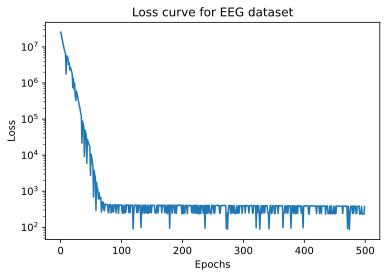

In [41]:
# plot learning curve
plt.plot(np.arange(len(losses)),losses)
plt.yscale("log")
plt.title("Loss curve for EEG dataset")
plt.ylabel("Loss")
plt.xlabel("Epochs")

### Plot the reconstruction

We can now plot examples of how the model reconstructs the input.

In [42]:
rec = eye_model.predict(data,mask,delta,replace=True)

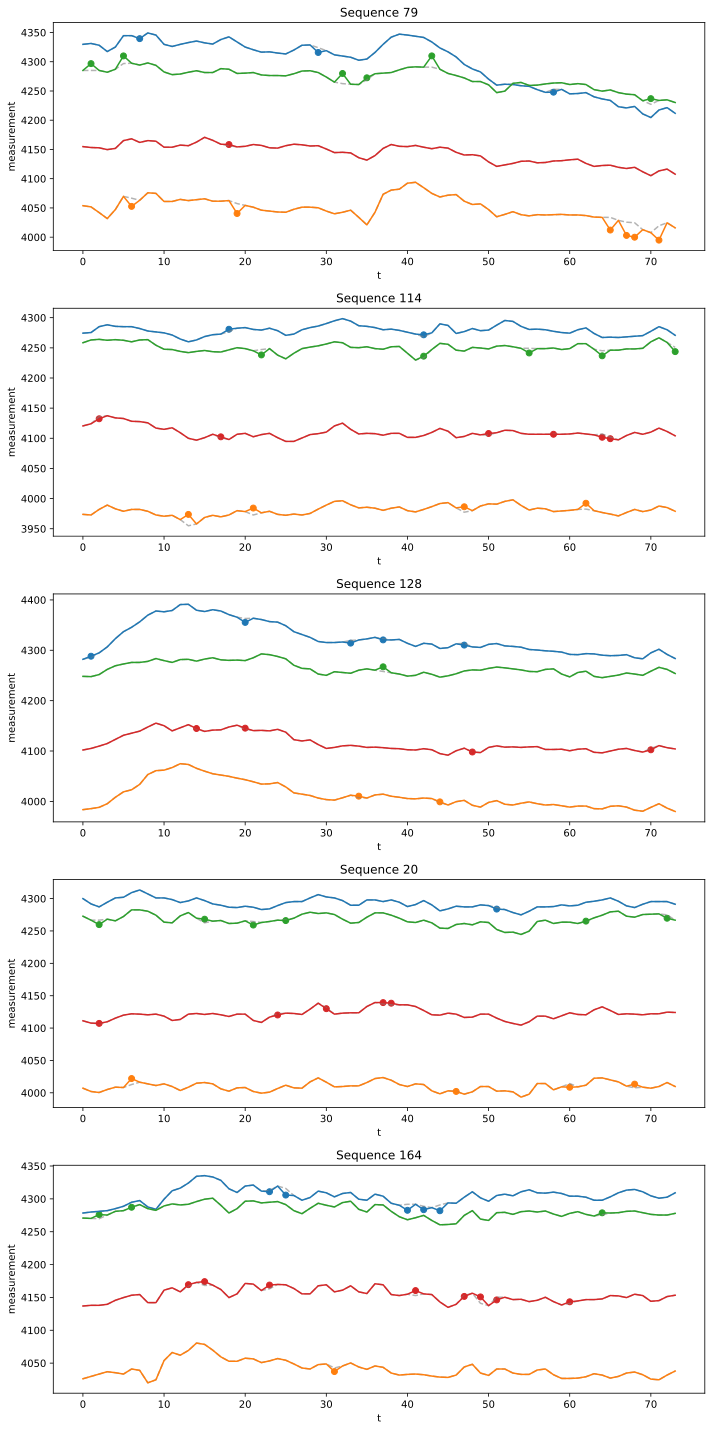

In [43]:
# Plot result
plt.figure(figsize=(10,20))
for row in range(5):
    randidx = np.random.randint(0,rec.shape[0])
    
    plt.subplot(5,1,(row+1))
    plt.title("Sequence {}".format(randidx))
    plt.xlabel("t")
    plt.ylabel("measurement")
    missing = (mask[randidx]==0).cpu()
    for dim in range(4):
        plt.plot(np.arange(74),ground_truth[randidx,dim,:].cpu(),linestyle="dashed",c="grey",alpha=0.6)
        plt.plot(np.arange(74),rec[randidx,dim,:].cpu())
        plt.scatter(np.arange(74)[missing[dim]],rec[randidx,dim,:][missing[dim]].cpu())
plt.tight_layout()

### Save model

In [ ]:
# Specify a path
PATH = "eye_state_model2.pt"

# Save
torch.save(eye_model.state_dict(), PATH)

# save loss histories
with open("trainloss.npy","wb") as f:
    np.save(f, losses)

## Thoughts about further improvements

- Scale/Normalize all features (we didnt do this for visibility purposes).
- Regularization (in the paper dropout is used).
- Learn initial hidden state $h_{t=0}$ and $h_{t=T+1}$ as well as initial actual state $x_{t=0}$ and $x_{t=T+1}$. In normal RNN, we can also learn the initial hidden states, but in M-RNN, because we always use $x_{t-1}$ or $x_{t+1}$ as input (and not $x_t$ itself), we can treat those as learnable parameters as well. The authors don't mention how to deal with this.
- Use GRU cells instead of RNN potentially.
- Use more hidden layers (in our example, we only use one hidden layer in the interpolater, and one hidden layer in the imputer).
- Use different initial interpolation

## Literature

[1] Z. Che, S. Purushotham, K. Cho, D. Sontag, and Y. Liu, “Recurrent neural networks for multivariate time series with missing
values". 2016.

[2] F. Gingras and Y. Bengio, “Recurrent neural networks for missing or asynchronous data”. 1996.

[3] D. M. Kreindler and C. J. Lumsden, “The effects of the irregular sample and missing data in time series analysis”. 2012.

[4] S. Parveen and P. Green, “Speech recognition with missing data using recurrent neural nets”.2001.

[5] D. B. Rubin "Multiple imputation for nonresponse in surveys".1987.

[6] J. Yoon, W. R. Zamey, M. van der Schaar , "Estimating Missing Data in Temporal Data Streams Using Multi-directional Recurrent Neural Networks". 2017

[7] https://github.com/jsyoon0823/MRNN, Original code of M-RNN by Yoon et al.

## Backup

